In [1]:
# Ugly incantation to make our 'framework' working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools (paths, cache, print,zip,excel, pandas, progress,..)
from Tools.all import *

# setup the name of our experiment
# it will be used to store every result in a unique place
EXPERIMENT='fast_nlu'
# Do a bit of checks before actually running long code
UNITARY_TEST = True
print_alert('You will use environment %s' % EXPERIMENT)

prepare_environnement(EXPERIMENT)


We have built the dataset before so it can be loaded quickly.
It contains everything we have in stock:
* basic features
* features on stop words (2 levels)
* features on stop words + lemmatized words
* entities
* newsgroups
* spacy similarity
* ret50 confidences
* ret6 confidences

and for training
* weight
* is_duplicate

we still have the content of questions but it could be suppressed : we don't use it anymore

In [2]:
train_dataframe=load_global_dataframe('train_clean_everything')
challenge_dataframe=load_global_dataframe('challenge_clean_everything')

print('train ',train_dataframe.shape)
print('challenge ',challenge_dataframe.shape)

assert set(all_numeric_columns(train_dataframe)) == set(all_numeric_columns(challenge_dataframe))
print('Looks like OK')

train  (404290, 225)
challenge  (2345796, 221)
Looks like OK


Display simple AUCs

In [3]:
from sklearn.metrics import roc_auc_score

def simple_AUC(dataframe,column_name):
    return roc_auc_score(y_true=dataframe['is_duplicate'],y_score=dataframe[column_name])

def simple_weighted_AUC(dataframe,column_name):
    return roc_auc_score(y_true=dataframe['is_duplicate'],y_score=dataframe[column_name],sample_weight=dataframe['weight'])

def show_AUC(dataframe,column_name):
    if 'weight' in dataframe.columns:
        print_bullet('Weighted AUC %s %f' % (column_name,simple_weighted_AUC(dataframe,column_name)))
    else:
        print_bullet('AUC %s %f' % (column_name,simple_AUC(dataframe,column_name)))
        

def display_simple_AUC(dataframe,column_name):
    palette = sns.color_palette()
    as_hist(dataframe[column_name][dataframe['is_duplicate']==1],bins="blocks",color=palette[3],label='Same',histtype='step')
    as_hist(dataframe[column_name][dataframe['is_duplicate']==0],bins="blocks",color=palette[2],label='Different',alpha = 0.75,histtype='step')
    plot.title('AUC %s : %f' % (column_name,simple_AUC(dataframe,column_name)) , fontsize=10)
    plot.xlabel(column_name)
    plot.ylabel('Nb')
    plot.legend()



def show_all_simple_AUC(dataframe):
    all =  all_numeric_columns(dataframe)
    print_section( 'Show AUC on %d unique features' % len(all))
    for name in all:
        show_AUC(dataframe,name)


show_all_simple_AUC(train_dataframe)

Just a couple of graphs to see how much our adjusted features are different than basic ones

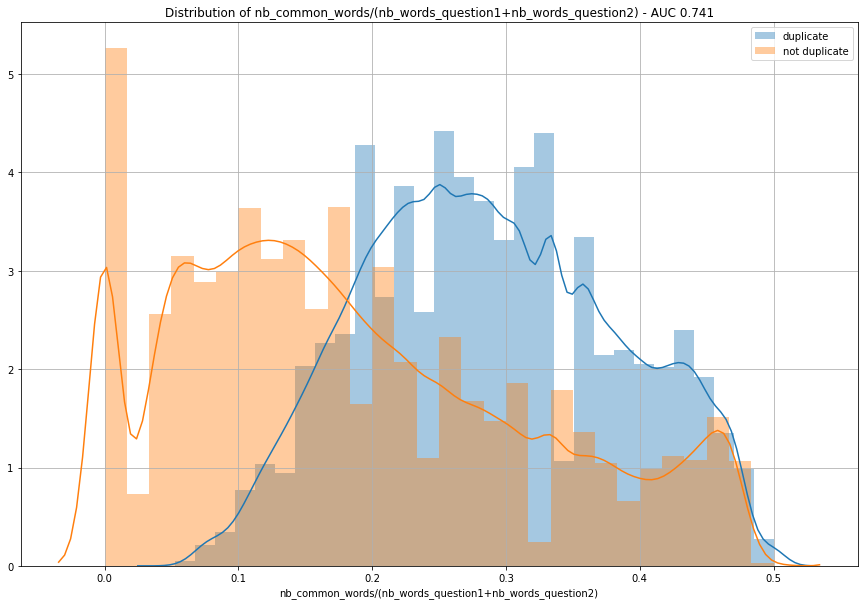

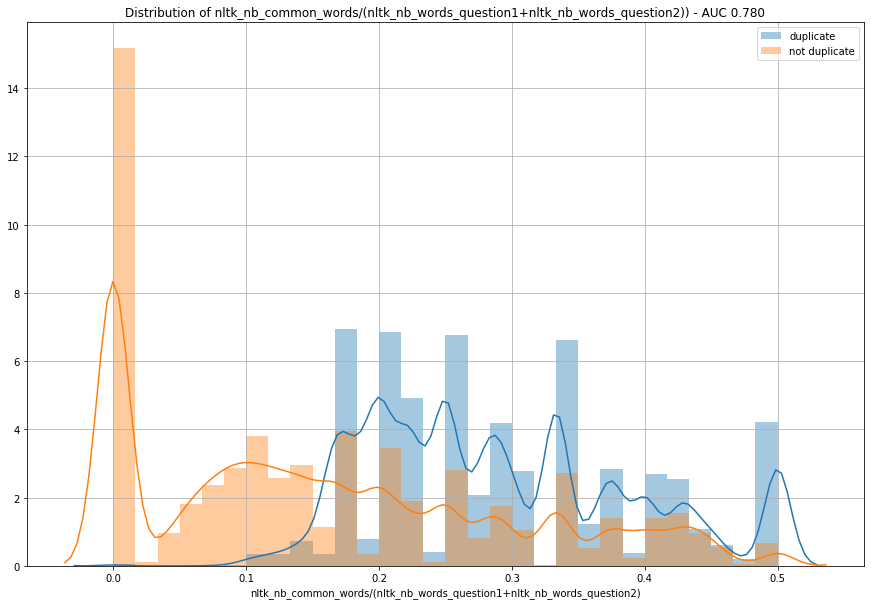

In [4]:
plot.figure(figsize=(15,10))
sns.distplot(train_dataframe[train_dataframe['is_duplicate']==1]['nb_common_words/(nb_words_question1+nb_words_question2)'], bins=30, label='duplicate', kde=True)  
sns.distplot(train_dataframe[train_dataframe['is_duplicate']==0]['nb_common_words/(nb_words_question1+nb_words_question2)'], bins=30,   label='not duplicate', kde=True)
plot.title('Distribution of nb_common_words/(nb_words_question1+nb_words_question2) - AUC %.3f' %simple_weighted_AUC(train_dataframe,'nb_common_words/(nb_words_question1+nb_words_question2)'))
plot.grid(True)
plot.legend()
plot_save('distribution_ratio_no_stopwords')

plot.figure(figsize=(15,10))
sns.distplot(train_dataframe[train_dataframe['is_duplicate']==1]['nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)'], bins=30, label='duplicate', kde=True)    
sns.distplot(train_dataframe[train_dataframe['is_duplicate']==0]['nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)'], bins=30,   label='not duplicate', kde=True)
plot.title('Distribution of nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)) - AUC %.3f' %simple_weighted_AUC(train_dataframe,'nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)'))
plot.grid(True)
plot.legend()
plot_save('distribution_ratio_nltk_stopwords')

Just focus on the correlation matrix of non semantic features

is_duplicate                                                                                1.000000
all_nb_common_words/(all_nb_words_question1+all_nb_words_question2)                         0.456488
nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)                      0.456047
all_nb_common_words/all_nb_words_question1                                                  0.447348
nltk_nb_common_words/nltk_nb_words_question1                                                0.445528
all_nb_common_words/all_nb_words_question2                                                  0.440822
nltk_nb_common_words/nltk_nb_words_question2                                                0.440107
lemmatized_nb_common_words/(lemmatized_nb_words_question1+lemmatized_nb_words_question2)    0.423128
clean_all_nb_common_words/(clean_all_nb_words_question1+clean_all_nb_words_question2)       0.422021
clean_all_nb_common_words/clean_all_nb_words_question1                                     

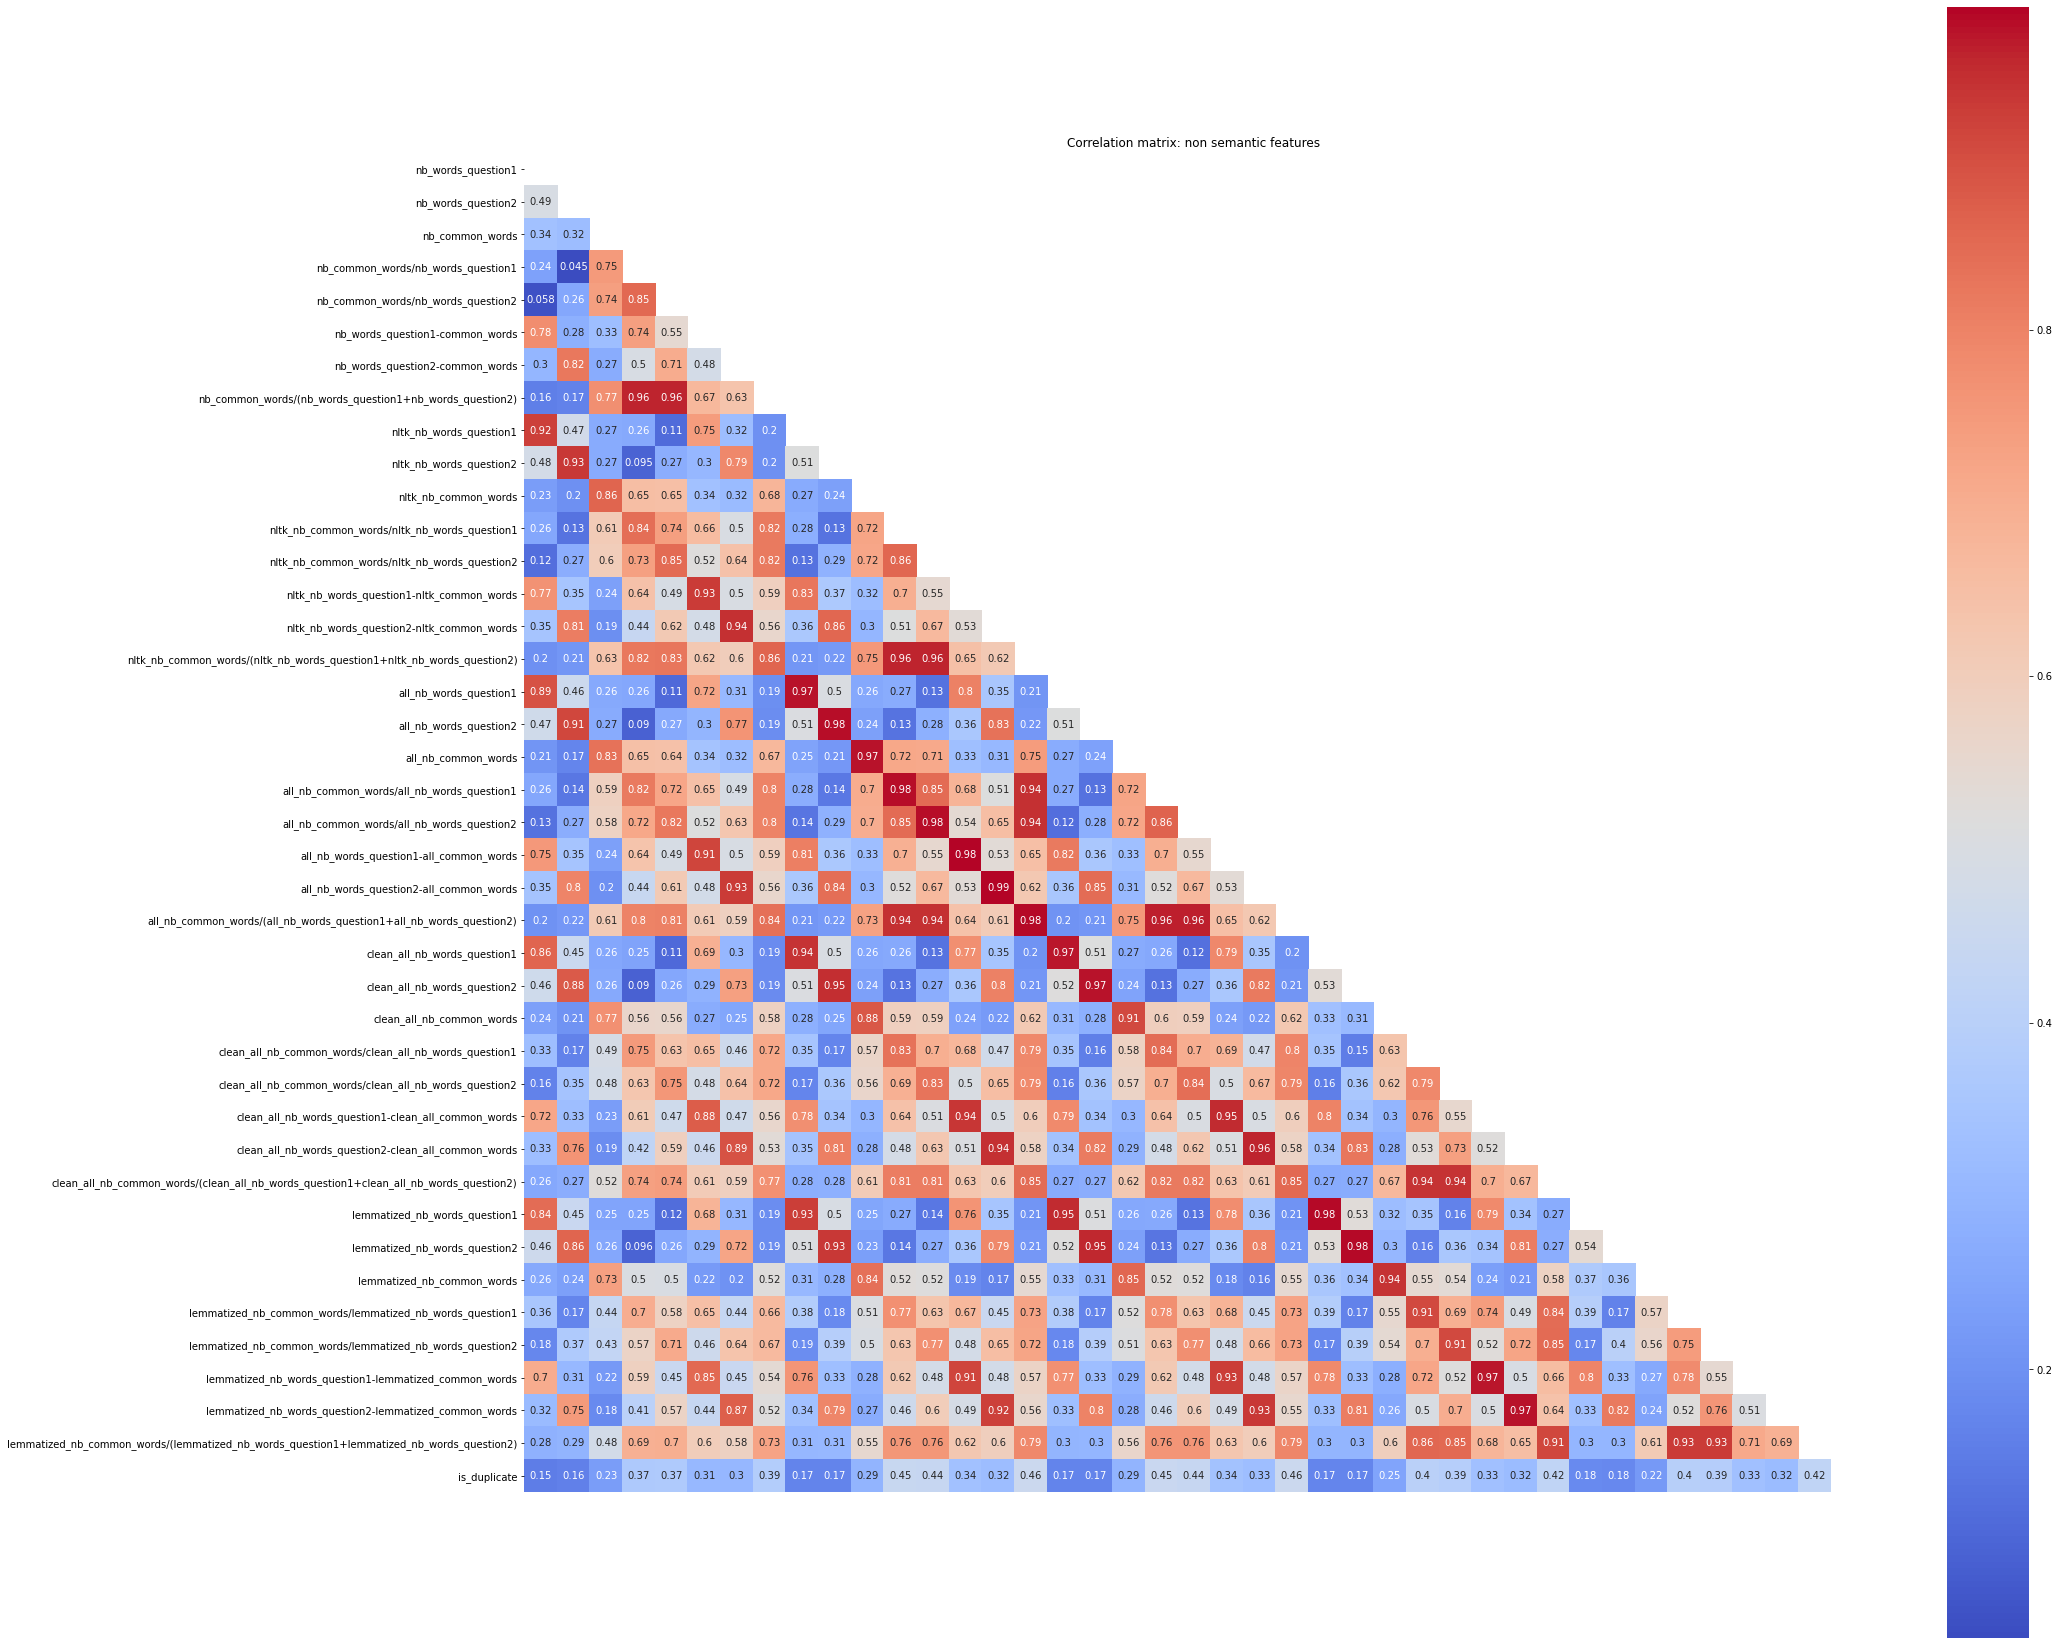

In [5]:
def show_correlation_matrix(input_df,columns):
        correlation_matrix = input_df[columns].corr().abs()
        print(correlation_matrix['is_duplicate'].nlargest(len(columns)))

        correlation_matrix_without_is_duplicate = correlation_matrix['is_duplicate'][correlation_matrix['is_duplicate']<1]
        highest_correlated_feature = correlation_matrix_without_is_duplicate.nlargest(1).index[0]
        highest_correlation = correlation_matrix_without_is_duplicate.nlargest(1)[0]
        if highest_correlation >0.2:
            if highest_correlation < 0.5:
                print_warning('%s is the most correlated with target but %f is quite weak' % (highest_correlated_feature,highest_correlation))
            else:
                print_info('%s is the most correlated with target but %f is very weak' % (highest_correlated_feature,highest_correlation))
        else:
            print_alert('%s is the most correlated with target and %f is quite big' % (highest_correlated_feature,highest_correlation))
        plot.figure(figsize=(30, 30))
        plot.title('Correlation matrix: non semantic features')
        sns.heatmap(correlation_matrix,annot=True,cbar=True,square=True,cmap='coolwarm',mask = numpy.triu(correlation_matrix),xticklabels=False)
        
NON_SEMANTIC_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'entities' not in c and 'news' not in c and 'proba' not in c and 'sim' not in c and 'confidence' not in c] 
NON_SEMANTIC_FEATURES.append('is_duplicate')

show_correlation_matrix(train_dataframe,NON_SEMANTIC_FEATURES)
plot_save('correlation_matrix_non_semantic_features')

A bunch of code to wrap xgboost

In [6]:
# Simple XGBoost code
# 

import xgboost 

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta' : 0.02,
    'max_depth':3 
    }

def print_res_xgboost(infos):
    # Glurk
    print_info(' | '.join([('%s '+f) % (k,infos[k]) for k,f in INFO_XGBOOST_MODEL.items() if k in infos]))

# 80% training 20% validation
def build_XGBoost_model_80_20(training,target,column_names,show=True):
    input_train,input_test,target_train,target_test = train_test_split(training,target,random_state=42,test_size=0.2)
    final_input_train = input_train[list(column_names)]
    final_input_test = input_test[list(column_names)]
    train_dm = xgboost.DMatrix(final_input_train, label = target_train, weight = input_train[WEIGHT],nthread = -1)
    validation_dm = xgboost.DMatrix(final_input_test, label = target_test,weight = input_test[WEIGHT])
    watchlist = [(train_dm, 'train'), (validation_dm, 'valid')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params,train_dm,400,watchlist,early_stopping_rounds=50,verbose_eval=verbose)
    infos = compute_metrics_model_xgboost(model,final_input_test,target_test,sample_weight = input_test[WEIGHT],show=show)
    duration = time.time()-start
    infos.update({'time':duration})
    if show:      
        print_res_xgboost(infos)
    return  infos

# Pushing the limits :100 % training no validation !!
# Just in case it allows to gain small digits in kaggle score...
# Actually not used ...
def build_XGBoost_model_100_0(training,target,column_names,show=True):
    final_train = training[list(column_names)]
    final_target = target
    final_weight = training[WEIGHT]

    train_dm = xgboost.DMatrix(final_train, label = final_target, weight = final_weight,nthread = -1)
    watchlist = [(train_dm, 'train')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params,train_dm,400,watchlist,early_stopping_rounds=50,verbose_eval=verbose)
    duration = time.time()-start
    infos = compute_metrics_model_xgboost(model,final_train,final_target,sample_weight = final_weight,show=show)
    infos.update({'time':duration})
    if show:      
        print_res_xgboost(infos)
    return  infos

def compute_metrics_model_xgboost(model,input_df,target_df,sample_weight = None,show = True):
    final_input = xgboost.DMatrix(input_df)
    prediction_proba_df = model.predict(final_input,ntree_limit=model.best_ntree_limit)
    # Hum shouldn't we challenge this 50% threshold ?
    prediction_df = numpy.where(prediction_proba_df>0.5,1,0)
    res = metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight,output_dict=True)
    accuracy = res['accuracy']
    score = res['weighted avg']['f1-score']
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df,sample_weight = sample_weight)
    if show:
        print_info('Classification report')
        print(metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight))
    return {
             'accuracy':accuracy,
             'score':score,
             'logloss_proba':logloss_proba,
             'model':model
           }

INFO_XGBOOST_MODEL= {
    'logloss_proba': '%.4f',
    'score': '%.4f',
    'accuracy': '%.4f',
    'time': '%.2f'
}

if UNITARY_TEST:
    print_section('Unitary test : playbox XGBoost 80_20')
    small_train = train_dataframe.sample(1000,random_state=42)
    print_section('Unitary test : playbox XGBoost 100_0')
    res = build_XGBoost_model_100_0(small_train,small_train['is_duplicate'],all_numeric_columns(small_train))
    print(res)

if UNITARY_TEST:
    print_section('Unitary test : playbox XGBoost 80_20')
    small_train = train_dataframe.sample(1000,random_state=42)
    print_section('Unitary test : playbox XGBoost 80_20')
    res = build_XGBoost_model_80_20(small_train,small_train['is_duplicate'],all_numeric_columns(small_train))
    print(res)

[0]	train-logloss:0.68191
Will train until train-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.59005
[20]	train-logloss:0.52473
[30]	train-logloss:0.47624
[40]	train-logloss:0.43911
[50]	train-logloss:0.41049
[60]	train-logloss:0.38744
[70]	train-logloss:0.36885
[80]	train-logloss:0.35295
[90]	train-logloss:0.33969
[100]	train-logloss:0.32867
[110]	train-logloss:0.31960
[120]	train-logloss:0.31170
[130]	train-logloss:0.30522
[140]	train-logloss:0.29942
[150]	train-logloss:0.29429
[160]	train-logloss:0.28919
[170]	train-logloss:0.28450
[180]	train-logloss:0.28029
[190]	train-logloss:0.27630
[200]	train-logloss:0.27292
[210]	train-logloss:0.26934
[220]	train-logloss:0.26541
[230]	train-logloss:0.26180
[240]	train-logloss:0.25803
[250]	train-logloss:0.25465
[260]	train-logloss:0.25088
[270]	train-logloss:0.24701
[280]	train-logloss:0.24420
[290]	train-logloss:0.24101
[300]	train-logloss:0.23786
[310]	train-logloss:0.23505
[320]	train-logloss:0.23223
[330]	train-logloss:0.2291

              precision    recall  f1-score   support

           0       0.92      1.00      0.96 833.5098453967706
           1       0.99      0.56      0.72 171.66892895091271

    accuracy                           0.92 1005.1787743476833
   macro avg       0.95      0.78      0.84 1005.1787743476833
weighted avg       0.93      0.92      0.92 1005.1787743476833



{'accuracy': 0.9243623066294024, 'score': 0.9156718237724215, 'logloss_proba': 0.21092878848449984, 'model': <xgboost.core.Booster object at 0x7f4d169e1df0>, 'time': 32.04087781906128}


[0]	train-logloss:0.68200	valid-logloss:0.68156
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.59063	valid-logloss:0.58683
[20]	train-logloss:0.52461	valid-logloss:0.52093
[30]	train-logloss:0.47618	valid-logloss:0.47270
[40]	train-logloss:0.43907	valid-logloss:0.43662
[50]	train-logloss:0.40980	valid-logloss:0.40954
[60]	train-logloss:0.38661	valid-logloss:0.38886
[70]	train-logloss:0.36775	valid-logloss:0.37242
[80]	train-logloss:0.35257	valid-logloss:0.35935
[90]	train-logloss:0.33975	valid-logloss:0.35041
[100]	train-logloss:0.32886	valid-logloss:0.34321
[110]	train-logloss:0.31952	valid-logloss:0.33724
[120]	train-logloss:0.31130	valid-logloss:0.33239
[130]	train-logloss:0.30399	valid-logloss:0.32860
[140]	train-logloss:0.29778	valid-logloss:0.32515
[150]	train-logloss:0.29198	valid-logloss:0.32227
[160]	train-logloss:0.28642	valid-logloss:0.31996
[170]	trai

              precision    recall  f1-score   support

           0       0.86      0.97      0.91 168.7955573880411
           1       0.58      0.21      0.31 33.5771183347514

    accuracy                           0.84 202.37267572279248
   macro avg       0.72      0.59      0.61 202.37267572279248
weighted avg       0.81      0.84      0.81 202.37267572279248



{'accuracy': 0.8432726572471984, 'score': 0.811638497752863, 'logloss_proba': 0.3115694782603948, 'model': <xgboost.core.Booster object at 0x7f4d14175940>, 'time': 3.247724771499634}


Before launching bigh models, let's check again what we have. Here are the numeric columns (ids and target have been removed) in train dataset

In [7]:
assert set(all_numeric_columns(train_dataframe)) == set(all_numeric_columns(challenge_dataframe)), 'Oups train and challenge do not have the same numeric columns'
print_info('train and challenge datasets have the same numeric columns ')
i = 1
for c in all_numeric_columns(train_dataframe):
    print(i,c)
    i +=1

1 nb_words_question1
2 nb_words_question2
3 nb_common_words
4 nb_common_words/nb_words_question1
5 nb_common_words/nb_words_question2
6 nb_words_question1-common_words
7 nb_words_question2-common_words
8 nb_common_words/(nb_words_question1+nb_words_question2)
9 nltk_nb_words_question1
10 nltk_nb_words_question2
11 nltk_nb_common_words
12 nltk_nb_common_words/nltk_nb_words_question1
13 nltk_nb_common_words/nltk_nb_words_question2
14 nltk_nb_words_question1-nltk_common_words
15 nltk_nb_words_question2-nltk_common_words
16 nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)
17 all_nb_words_question1
18 all_nb_words_question2
19 all_nb_common_words
20 all_nb_common_words/all_nb_words_question1
21 all_nb_common_words/all_nb_words_question2
22 all_nb_words_question1-all_common_words
23 all_nb_words_question2-all_common_words
24 all_nb_common_words/(all_nb_words_question1+all_nb_words_question2)
25 clean_all_nb_words_question1
26 clean_all_nb_words_question2
27 clean_all_nb

In [8]:
ALL_FEATURES=all_numeric_columns(train_dataframe)
print_info('We have %d features' % len(ALL_FEATURES))
display(pandas.DataFrame(ALL_FEATURES,columns=['feature']))

,feature
0,nb_words_question1
1,nb_words_question2
2,nb_common_words
3,nb_common_words/nb_words_question1
4,nb_common_words/nb_words_question2
...,...
210,2_6_ABBR_confidence
211,2_6_HUM_confidence
212,2_6_LOC_confidence
213,2_6_DESC_confidence


Let's check again the impact of entities

In [9]:
ALL_NB_ENTITIES=[c for c in all_numeric_columns(train_dataframe) if 'enti' in c and 'ratio' not in c]
print(ALL_NB_ENTITIES)
def sniff_entities(r):
    for c in ALL_NB_ENTITIES:
        if r[c]>0:
            return 1
    return 0

res = train_dataframe.progress_apply(sniff_entities,axis=1)
print_info('%.2f %% of pairs have some detected entities' % (res.mean()*100.))

['nb_entities_GPE_question1', 'nb_entities_PERSON_question1', 'nb_entities_PRODUCT_question1', 'nb_entities_ORG_question1', 'nb_entities_DATE_question1', 'nb_entities_NORP_question1', 'nb_entities_WORK_OF_ART_question1', 'nb_entities_LANGUAGE_question1', 'nb_entities_EVENT_question1', 'nb_entities_FAC_question1', 'nb_entities_LAW_question1', 'nb_entities_LOC_question1', 'nb_entities_GPE_question2', 'nb_entities_PERSON_question2', 'nb_entities_PRODUCT_question2', 'nb_entities_ORG_question2', 'nb_entities_DATE_question2', 'nb_entities_NORP_question2', 'nb_entities_WORK_OF_ART_question2', 'nb_entities_LANGUAGE_question2', 'nb_entities_EVENT_question2', 'nb_entities_FAC_question2', 'nb_entities_LAW_question2', 'nb_entities_LOC_question2', 'nb_entities_common_GPE', 'nb_entities_common_PERSON', 'nb_entities_common_PRODUCT', 'nb_entities_common_ORG', 'nb_entities_common_DATE', 'nb_entities_common_NORP', 'nb_entities_common_WORK_OF_ART', 'nb_entities_common_LANGUAGE', 'nb_entities_common_EVENT

Another bunch of code. Just wrappers so we do in one shot:
* generate a set of models given a set of columns
* keep their results in memory
* save all models to excel
* dump everything (including the models) in a cache so all previous steps can be done in a sec
* find the best model (related to logloss)
* generate a file of predictions suitable for kaggle
* prepare everything for a kaggle submission
* show the statement to do the submission to kaggle


Current exploration methods available, given n columns
* generate models using from 1 to n columns (215 columns will generate 215 models)
* only one model with all the columns provided as parameter

In [10]:
def find_best_result(results,metric):
    if 'logloss' in metric:
        return results.nsmallest(1,metric)
    else:
        return results.nlargest(1,metric)
        
def apply_xgboost(model,columns,input_df):
    res = pandas.DataFrame()
    res['test_id'] = input_df['test_id']
    res['is_duplicate'] = model.predict(xgboost.DMatrix(input_df[columns]))
    return res

def submit_best_result(results,input_df,file_name,kaggle_message,metric='logloss_proba'):
    start = time.time()
    print_section("Scoring XGBoost model with best %s: %s" % (metric,kaggle_message))
    csv_file_name = absolute_env_file_name(file_name,ext='.csv')
    print_info('Generating scores in %s' % csv_file_name)
    best = find_best_result(results,metric)
    model = best['model'][0]
    columns = best['columns'][0]
    prediction = apply_xgboost(model,columns,input_df)
    prediction.to_csv(csv_file_name,index=False)
    print_info('Zipping file')
    absolute_file_name_zip = zip_file_and_delete(csv_file_name)
    print_done('Done',top=start)
    print_info('%s is ready' % absolute_file_name_zip)
    print_warning('Use this commands to submit apply results to kaggle')
    print_warning('kaggle competitions submit quora-question-pairs -f "%s" -m "%s %s"' % (absolute_file_name_zip,EXPERIMENT,kaggle_message))
    return prediction

def n_columns(columns,n):
    return columns[0:n]

def xgboost_80_20_one_more_field_at_a_time(dataframe,columns_to_explore,explore=True,show=False):
    if explore:
        print_section("XGBoost (80,20) on 1 to %d fields" % len(columns_to_explore))
    else:
        print_section("XGBoost (80,20) on %d fields" % len(columns_to_explore))
    start = time.time()
    res_final = dict()
    min_log_loss = 1000
    best = 0
    best_cols =''
    # a shortcut is possible
    if explore:
        first_nb = 1
    else:
        first_nb=len(columns_to_explore)
    for i in tqdm(range(first_nb,len(columns_to_explore)+1)):
        columns = n_columns(columns_to_explore,i)
        res = build_XGBoost_model_80_20(dataframe,dataframe['is_duplicate'],columns,show = show)
        cur_logloss = res['logloss_proba']
        cur_accuracy = res['accuracy']
        cur_score = res['score']
        if cur_logloss<min_log_loss:
            print_info("%d:%.4f %.4f %.4f" % (i,cur_logloss,cur_accuracy,cur_score))
            min_log_loss = cur_logloss
            best_cols = columns
            best = i
        else:
            print_warning("%d:%.4f %.4f %.4f" % (i,cur_logloss,cur_accuracy,cur_score))
        res.update( {'columns':columns})
        res_final.update({str(i):res})
    print_info('Best: %d %.4f %s' % (best,min_log_loss,best_cols))
    print_done('Done',top=start)
    return pandas.DataFrame.from_dict(res_final, orient='index')

# try to reload from cache an exploration
# if not available, redo it and save results in cache
# find the best result according to a metric (default logloss_proba)
# and submit it to kaggle
def study_models_one_more_field_at_a_time(message,tag,columns,train_df,challenge_df,explore=True,show=False):
    print_section(message)
    results = load_or_build_dataframe('Rebuild XGBoost models',tag + '_results',lambda df:xgboost_80_20_one_more_field_at_a_time(df,columns,explore=explore,show=show),train_df)
    save_models_dict_to_excel(results,tag=tag)
    display(results.describe())
    submit_best_result(results,challenge_df,'Best_'+tag,'Best ' + tag)
    return results

### build a model one field at a time

A little bit long but results are saved in a cache so next time will be fast
## Do not delete  everything_results.pkl otherwise you will need around 10h with a 8 core server

In [11]:
xgboost_everything_results = study_models_one_more_field_at_a_time(
    'everything',
    'everything',
    ALL_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore = True,
    show = False)

,accuracy,score,logloss_proba,time
count,215.000000,215.000000,215.000000,215.000000
mean,0.832933,0.781555,0.333022,134.226628
std,0.002571,0.009613,0.015279,94.763001
min,0.823848,0.744278,0.325158,17.647141
25%,0.833728,0.784751,0.326930,49.286705
50%,0.833958,0.785025,0.328644,110.498374
75%,0.834136,0.786215,0.331551,212.894371
max,0.834696,0.786997,0.454579,329.834376


We graph the logloss obtained adding one field at a time from:
* basic features on non processed data
* same features with a first set of stop words removed
* same features with more stop words removed
* same features with more stop words after cleaning
* same features with more stop words after cleaning and lemmatisation
* Entities 
* newsgroups
* similarity computed by spacy lib

Obviously, this graph does not prove anything as another order of fields would generate a totally different graph but we can still say:
* all preprocessing informations provide some enhancement
* expanding list of stop words provides only marginal enhancement. **Again**, this does not mean features built with full list of stop words does not provide informations. It does provide a little bit more information to the ones already available
* lemmatisation is useful in our context
* entities do not provide much more informations
* spacy similarity does enhance the model but not dramatically
* optimising hyperparameters is quite efficient

Challenging the need of a feature on the final model is done later

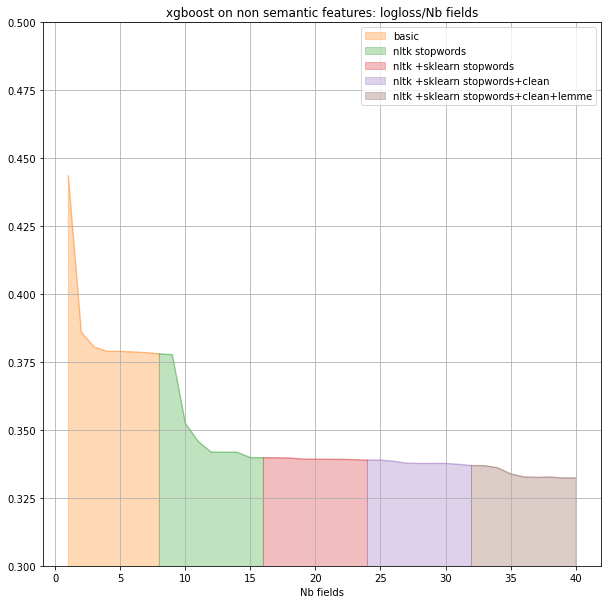

In [12]:
plot.figure(figsize=(10,10))

pal=sns.color_palette()
plot.ylim(0.3,0.5)
plot.plot(numpy.arange(1,9,1),xgboost_everything_results['logloss_proba'][1:9],color=pal[1],alpha=0.3)
plot.fill_between(numpy.arange(1,9,1),xgboost_everything_results['logloss_proba'][1:9],label='basic',color=pal[1],alpha=0.3)

plot.plot(numpy.arange(8,17,1),xgboost_everything_results['logloss_proba'][8:17],color=pal[2],alpha=0.3)
plot.fill_between(numpy.arange(8,17,1),xgboost_everything_results['logloss_proba'][8:17],label='nltk stopwords',color=pal[2],alpha=0.3)

plot.plot(numpy.arange(16,25,1),xgboost_everything_results['logloss_proba'][16:25],color=pal[3],alpha=0.3)
plot.fill_between(numpy.arange(16,25,1),xgboost_everything_results['logloss_proba'][16:25],label='nltk +sklearn stopwords',color=pal[3],alpha=0.3)

plot.plot(numpy.arange(24,33,1),xgboost_everything_results['logloss_proba'][24:33],color=pal[4],alpha=0.3)
plot.fill_between(numpy.arange(24,33,1),xgboost_everything_results['logloss_proba'][24:33],label='nltk +sklearn stopwords+clean',color=pal[4],alpha=0.3)

plot.plot(numpy.arange(32,41,1),xgboost_everything_results['logloss_proba'][32:41],color=pal[5],alpha=0.3)
plot.fill_between(numpy.arange(32,41,1),xgboost_everything_results['logloss_proba'][32:41],label='nltk +sklearn stopwords+clean+lemme',color=pal[5],alpha=0.3)

plot.title('xgboost on non semantic features: logloss/Nb fields')
plot.xlabel('Nb fields')
plot.grid(True)
plot.legend()
plot_save('xgboost_all_features_all_preprocess_non_semantic')

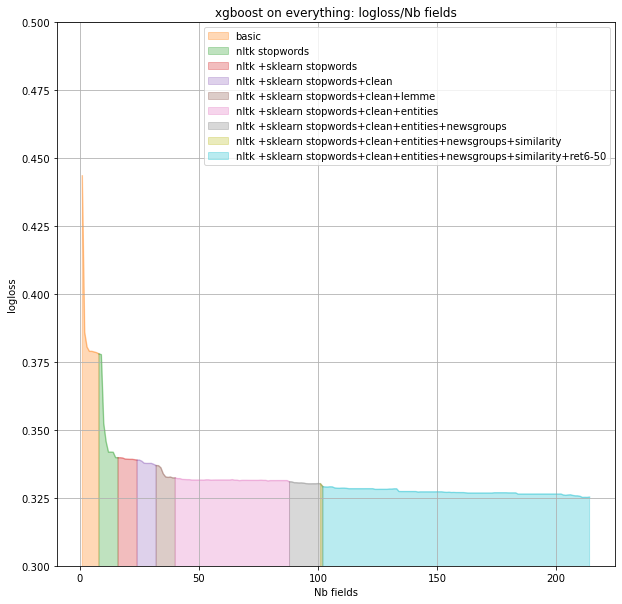

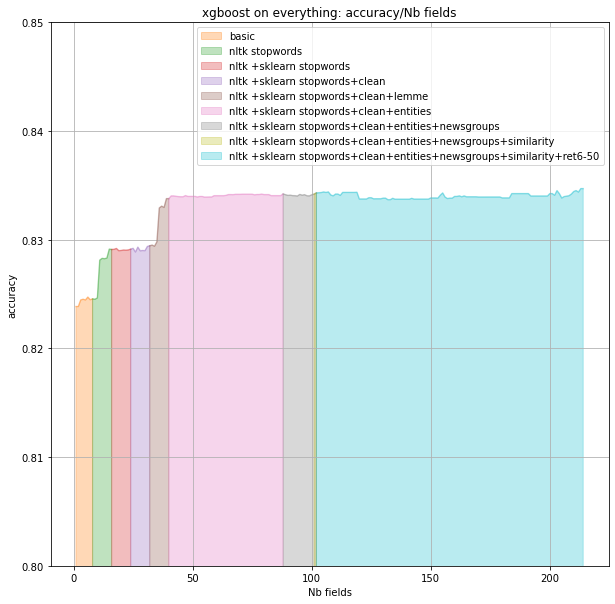

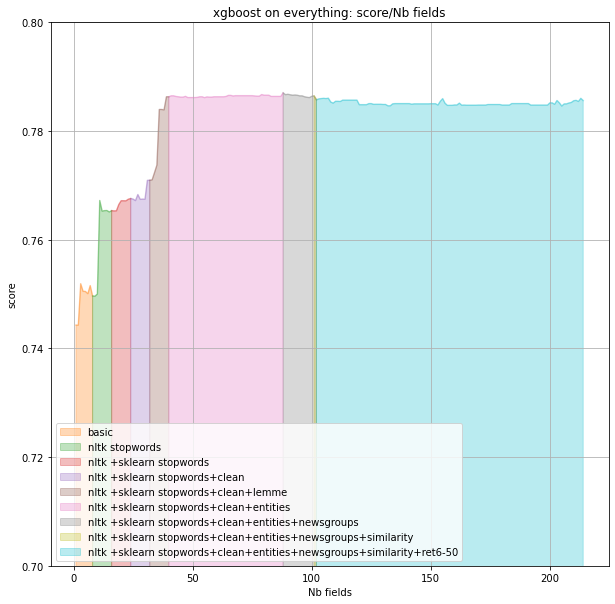

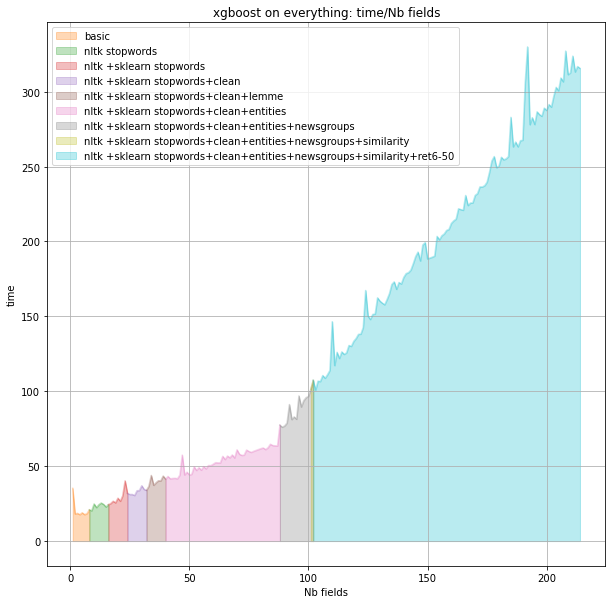

In [23]:
def show_progress(result,metric,limit_min=None,limit_max=None):
    plot.figure(figsize=(10,10))

    pal=sns.color_palette()
    if limit_min != None and limit_max != None:
        plot.ylim(limit_min,limit_max)
    
    plot.plot(numpy.arange(1,9,1),result[1:9],color=pal[1],alpha=0.3)
    plot.fill_between(numpy.arange(1,9,1),result[1:9],label='basic',color=pal[1],alpha=0.3)

    plot.plot(numpy.arange(8,17,1),result[8:17],color=pal[2],alpha=0.3)
    plot.fill_between(numpy.arange(8,17,1),result[8:17],label='nltk stopwords',color=pal[2],alpha=0.3)

    plot.plot(numpy.arange(16,25,1),result[16:25],color=pal[3],alpha=0.3)
    plot.fill_between(numpy.arange(16,25,1),result[16:25],label='nltk +sklearn stopwords',color=pal[3],alpha=0.3)

    plot.plot(numpy.arange(24,33,1),result[24:33],color=pal[4],alpha=0.3)
    plot.fill_between(numpy.arange(24,33,1),result[24:33],label='nltk +sklearn stopwords+clean',color=pal[4],alpha=0.3)

    plot.plot(numpy.arange(32,41,1),result[32:41],color=pal[5],alpha=0.3)
    plot.fill_between(numpy.arange(32,41,1),result[32:41],label='nltk +sklearn stopwords+clean+lemme',color=pal[5],alpha=0.3)

    plot.plot(numpy.arange(40,89,1),result[40:89],color=pal[6],alpha=0.3)
    plot.fill_between(numpy.arange(40,89,1),result[40:89],label='nltk +sklearn stopwords+clean+entities',color=pal[6],alpha=0.3)

    plot.plot(numpy.arange(88,103,1),result[88:103],color=pal[7],alpha=0.3)
    plot.fill_between(numpy.arange(88,103,1),result[88:103],label='nltk +sklearn stopwords+clean+entities+newsgroups',color=pal[7],alpha=0.3)

    plot.plot(numpy.arange(101,103,1),result[101:103],color=pal[8],alpha=0.3)
    plot.fill_between(numpy.arange(101,103,1),result[101:103],label='nltk +sklearn stopwords+clean+entities+newsgroups+similarity',color=pal[8],alpha=0.3)
    
    plot.plot(numpy.arange(102,215,1),result[102:215],color=pal[9],alpha=0.3)
    plot.fill_between(numpy.arange(102,215,1),result[102:215],label='nltk +sklearn stopwords+clean+entities+newsgroups+similarity+ret6-50',color=pal[9],alpha=0.3)
        
    plot.title('xgboost on everything: '+ metric+ '/Nb fields')
    plot.xlabel('Nb fields')
    plot.ylabel(metric)
    plot.grid(True)
    plot.legend()
    plot_save('xgboost_progress_'+metric+'_everything')

show_progress(xgboost_everything_results['logloss_proba'],'logloss',0.3,0.5)
show_progress(xgboost_everything_results['accuracy'],'accuracy',0.8,0.85)
show_progress(xgboost_everything_results['score'],'score',0.7,0.8)
show_progress(xgboost_everything_results['time'],'time')#,0.3,0.5)

This was with default xgboost parameters
We have optimized xgboost parameters on a google instance (96 cores!)

Here are the models with best parameters

In [ ]:
#All without ret optimized on my laptop
params= {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'colsample_bytree': 0.7000000000000001,
    'eta': 0.05,
    'gamma': 0.8500000000000001,
    'max_depth': 11,
    'min_child_weight': 3.0,
    'n_estimators': 868.0,
    'subsample': 0.9500000000000001}
#all : everything we have optimized on a big google instance
params= {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'colsample_bytree': 0.9,
     'eta': 0.05,
     'gamma': 0.7000000000000001,
     'max_depth': 10,
     'min_child_weight': 5.0,
     'n_estimators': 959.0,
     'subsample': 0.8500000000000001}

xgboost_best_optim_everything = study_models_one_more_field_at_a_time(
    'everything optim',
    'everything_optim',
    ALL_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore = False,
    show = False)